[<img src='https://github.com/jeshraghian/snntorch/blob/master/docs/_static/img/snntorch_alpha_w.png?raw=true' width="300">](https://github.com/jeshraghian/snntorch/)

# The Forward-Forward Algorithm
### Tutorial written by Ethan Mulle and Abhinandan Singh


The following tutorial introduces how to implement the Forward-Forward algorithm proposed by Geoffrey Hinton into a spiking neural network (SNN).
> <cite> [Geoffrey Hinton. The Forward-Forward Algorithm: Some Preliminary
Investigations. 2022. arXiv: 2212.13345 [cs.LG].](https://arxiv.org/abs/2212.13345) </cite>

For a comprehensive overview on how SNNs work, and what is going on under the hood, [then you might be interested in the snnTorch tutorial series available here.](https://snntorch.readthedocs.io/en/latest/tutorials/index.html)
The snnTorch tutorial series is based on the following paper. If you find these resources or code useful in your work, please consider citing the following source:

> <cite> [Jason K. Eshraghian, Max Ward, Emre Neftci, Xinxin Wang, Gregor Lenz, Girish Dwivedi, Mohammed Bennamoun, Doo Seok Jeong, and Wei D. Lu. "Training Spiking Neural Networks Using Lessons From Deep Learning". Proceedings of the IEEE, 111(9) September 2023.](https://ieeexplore.ieee.org/abstract/document/10242251) </cite>

- Run the below two cells to install snnTorch and then import PyTorch and snnTorch for use.

In [ ]:
!pip install snntorch --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.0/109.0 kB 3.2 MB/s eta 0:00:00


In [ ]:
import torch, torch.nn as nn
import snntorch as snn
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

## 1. The MNIST Dataset
For this tutorial, we will be using the MNIST dataset. MNIST is a dataset of 60,000 images in the training set and 10,000 images in the test set of grayscale handwritten numerical digits. The goal is to classify the digit written in each image between 0-9.


* The spatial dimensions of MNIST are $28\times 28$
* The image is grayscale so the channel size is $1$
* There are no time-varying components, so there is no sequence length


### 1.1 Dataloading

- Set up data loaders for the MNIST training and test datasets.

- Define a data transformation pipeline, and iterate over the first batch of the training loader to inspect the size of the data.

- The transformations include converting images to grayscale, transforming them to tensors, normalizing pixel values, and flattening the tensors.

In [ ]:
from torchvision.datasets import MNIST
from torchvision.transforms import Compose, Grayscale, ToTensor, Normalize, Lambda
from torch.utils.data import DataLoader

# **DATA TRANFORMATION FUNCTION**
# defines a data transformation pipeline using the 'Compose' class.
# the pipeline includes converting images to grayscale, transforming them to tensors, normalizing pixel values, and flattening the tensors.
transform = Compose([
    Grayscale(),
    ToTensor(),
    Normalize((0,), (1,)),
    Lambda(lambda x: torch.flatten(x))])


# **LOAD AND TRANFORM TRAIN DATA**
mnist_train = MNIST('./data/', train=True, download=True, transform=transform)
  # loads the MNIST training dataset with specified transformations.
train_loader = DataLoader(mnist_train, batch_size=50000, shuffle=True)
  # creates a DataLoader for the training dataset with a batch size of 50000 and shuffling enabled.

# **LOAD AND TRANFORM TEST DATA**
mnist_test = MNIST('./data/', train=False, download=True, transform=transform)
  # loads the MNIST test dataset with the same transformations as the training dataset.
test_loader = DataLoader(mnist_train, batch_size=10000, shuffle=False)
  # creates a DataLoader for the test dataset with a batch size of 10000.

# **ITERATE OVER TRAIN LOADER**
for data, label in iter(train_loader):
# initiates a loop to iterate over batches from the training loader.
  print(data.size())
    # prints the size of the first batch of data.
  break

100%|██████████| 9912422/9912422 [00:00<00:00, 154424511.55it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 38201101.81it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 48104859.92it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 24613086.26it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

torch.Size([50000, 784])


## 2. Forward-Forward Algorithm Theory
The Forward-Forward algorithm is a learning procedure inspired by Boltzmann machines and Noise Contrastive Estimation. The algorithm is illustrated in the figure below. It works by replacing the forward and backward passes of backpropagation with two forward passes - the positive pass and the negative pass. These passes operate in exactly the same way as each other, however, the positive pass works on real data to adjust the weights to increase the goodness in each layer, while the negative pass works on "bad" generated data to adjust the weights to decrease the goodness in each layer. As such, each layer has its own objective function that is locally updated in contrast to backpropagation which has a global objective function that is optimized.

![](https://drive.google.com/uc?export=view&id=1cYmOJ1goT4-Yb0ftucAwYYhYTfmesXZ6)

Goodness can be measured through a metric such as the sum of the squared neural activities. The aim of learning the the Forward-Forward algorithm is then to make the goodness be well above some threshold value for real data and well below that value for negative data. In practice, the aim is to correctly classify input vectors as positive data or negative data when the probability that an input vector is real is given by applying the logistic function, $\sigma$ to the goodness minus some threshold, $\theta$
\begin{equation}
    p(positive) = \sigma \left(\sum_j y_j^2 - \theta \right)
\end{equation}
where $y_j$ is the activity of hidden unit $j$ before layer normalization.

## 3. Implementation
We follow and modify the Forward-Forward algorithm implementation found here:
> <cite> [Mohammad Pezeshki. pytorch_forward_forward. Github Repo January 2023.](https://github.com/mpezeshki/pytorch_forward_forward) </cite>

To do so, we must define both a layer and a network class.

### 3.1 Defining the Layer Class
- Define 'LeakyLayer' class is a custom linear layer with additional attributes related to leaky integrate and fire, an Adam optimizer, a threshold value, and the number of training epochs. The class is designed to be used as a layer in a neural network.

- The 'forward' method defines the computations for a forward pass through the 'LeakyLayer'. It involves initializing the membrane potential, normalizing the input, computing the weighted input, passing it through a leaky integrate-and-fire neuron, and returning the resulting membrane potential

- The 'train' method performs a training loop over a specified number of epochs. It computes the goodness for positive and negative data, calculates the loss based on these goodness values, locally backpropagates the gradients, and updates the parameters using the optimizer. The method returns the membrane potentials for positive and negative data after training. The goal is to encourage positive goodness to be above the threshold and negative goodness to be below the threshold.

In [ ]:
from tqdm import tqdm
from torch.optim import Adam
import torch.nn.functional as F

# **CLASS DEFINITION**
class LeakyLayer(nn.Linear):
# defining a class named LeakyLayer that inherits from "nn.Linear"
# 'LeakyLayer' is a custom linear layer.

# **CONSTRUCTOR**
    def __init__(self, in_features, out_features, activation, bias=False):
    # define the constructor method for the 'LeakyLayer' class.
        super().__init__(in_features, out_features, bias=bias)
        # calls the constructor of the parent class ('nn.Linear') to initialize the linear layer with specified input and output features.
        if activation == "lif":
          self.activation = snn.Leaky(beta=0.8)
          self.lif = True
        else:
          self.activation = nn.ReLU()
          self.lif = False
        # decay rate = 0.8
        self.opt = Adam(self.parameters(), lr=0.03)
        # initializes an Adam optimizer for the parameters of the 'LeakyLayer' with a learning rate of 0.03
        self.threshold = 5.0
        # set the threshold value to 5.0
        self.num_epochs = 1000
        # specifies the number of epochs for training (1000 in this case).



# **FORWARD METHOD**
    def forward(self, x):
    # define the forward method of the 'LeakyLayer' class.
    # this method specifies the computation that occurs during the forward pass of the neural network.
        if self.lif == True:
          mem = self.activation.init_leaky()
        # initialize the membrane potential

        # **NORMALIZE INPUT**
        x_direction = x / (torch.norm(x, p=2, dim=1, keepdim=True) + 1e-4)
            # computes the Euclidean norm along dimension 1 of the input tensor 'x'
            # normalizes the input tensor x by dividing it by its L2 norm
            # '1e-4' is added to the denominator to prevent division by zero

        # **COMPUTE WEIGHTED INPUT**
        weighted_input = torch.mm(x_direction, self.weight.T.to(device))
            # matrix multiplication between the normalized input 'x_direction' and the transpose (T) of the weight matrix (self.weight)
            # The result is the weighted input to the neurons

        # **PASS THROUGH LIF NEURON**
        if self.lif == True:
          spk, potential = self.activation(weighted_input, mem)
        else:
          potential = self.activation(weighted_input)
            # passes the weighted input and the current membrane potential through the leaky integrate-and-fire (LIF) neuron model
            # returns spike value and updated membrane potential

        # **RETURN MEMBRANE POTENTIAL**
        return potential
            # forward method returns the updated membrane potential (potential)
            # this membrame potential can be used in subsequent layers (or as the final output of the last layer)



# **TRAIN METHOD**
    def train(self, x_pos, x_neg):
    # define the 'train' method of the 'LeakyLayer' class.
    # this method is responsible for training the layer using positive ('x_pos') and negative ('x_neg') examples.

        # **TRAINING LOOP**
        for _ in tqdm(range(self.num_epochs), desc="Training LeakyLayer"):
        # runs the loop for number of epochs = 1000

            # **COMPUTE GOODNESS**
            g_pos = self.forward(x_pos).pow(2).mean(1)
            g_neg = self.forward(x_neg).pow(2).mean(1)
              # Computes the goodness (g_pos and g_neg) for the positive and negative data
              # by performing the forward pass, squaring the results, and then computing the mean along dimension 1.

            # **COMPUTE LOSS**
            loss = F.softplus(torch.cat([-g_pos + self.threshold, g_neg - self.threshold])).mean()
              # Constructs a tensor by concatenating the positive and negative differences with a threshold
              # Applies the softplus activation function: log(1 + exp(x))
              # Computes the mean of the resulting tensor. This is the final scalar value representing the loss

            # **ZERO THE GRADIENTS**
            self.opt.zero_grad()
              # Zeros the gradients of the model parameters

            # **LOCAL BACKWARD PASS**
            loss.backward()
              # Computes the gradients of the loss with respect to the model parameters

            # **PARAMETERS UPDATE**
            self.opt.step()
              # Updates the model parameters using the optimizer (Adam optimizer in this case)

        # **RETURN ACTIVATIONS & DETACH**
        return self.forward(x_pos).detach(), self.forward(x_neg).detach()
          # returns the final membrane potentials (activations) for positive and negative examples after training.
          # the '.detach()' method is used to detach the returned tensors from the computation graph,
          # indicating that these are the final results and should not be used for further gradient computation during backpropagation

### 3.2 Defining the Network Class

- The 'Net' class is defined as a neural network with a constructor that takes a list of dimensions. It initializes a ModuleList ('self.layers') containing instances of the 'LeakyLayer' class, which represents the layers of the neural network. The use of 'nn.Module' as a base class allows PyTorch to track the network's architecture and parameters.

- The 'predict' method overlays label information onto the input, passes it through each layer of the neural network, computes goodness values at each layer, accumulates them for each label, and returns the predicted labels based on the maximum goodness.

- The 'train' method iterates over the layers of the neural network, prints information about the current layer being trained, and updates the input tensors ('h_pos' and 'h_neg') by calling the 'train' method of each layer. This allows the layers to learn and adapt their parameters during the training process.

In [ ]:
# **CLASS DEFINITON**
class Net(nn.Module):
  # define a new class named 'Net'.
  # this will be a network and inherits from 'nn.Module'

    # **CONSTRUCTOR METHOD**
    def __init__(self, dims, activation):
      # defines the constructor method for the 'Net' class.
      # this method is called when an instance of the class is created.
      # 'self' is a reference to the instance of the class.
      # 'dims' represents dimensions of the neura network layer.

        # **CALL TO PARENT CLASS CONSTRUCTOR**
        super().__init__()
          # calls the constructor of the parent class ('nn.Module')

        # **MODULE LIST FOR LAYERS**
        self.layers = nn.ModuleList([
            LeakyLayer(dims[d], dims[d + 1], activation) for d in range(len(dims) - 1)
        ])
          # creates instances of the 'LeakyLayer' class for each pair of consecutive dimensions in the 'dims' list.
          # it iterates over the range of 'len(dims) - 1' to ensure that there are enough dimensions for input and output for each layer.


    # **PREDICTION METHOD**
    def predict(self, x):
      # intended for making predictions using the neural network.
      # parameter 'self' is a reference to the instance of the class.
      # parameter 'x' is input data 'x' for which predictions are to be made.
        goodness_per_label = []
        # initializes an empty list to store the goodness values for each label.

        # **LOOP OVER LABELS**
        for label in range(10):
          # initiates a loop that iterates over each label from 0 to 9.

            # **OVERLAY FUNCTION**
            h = overlay_y_on_x(x, label)
              # Calls a function 'overlay_y_on_x' to overlay label information onto the input data 'x'.
              # The resulting tensor is assigned to 'h'.
            goodness = []

            # **INNER LOOP OVER LAYERS**
            for layer in self.layers:
              # initiates an inner loop over the layers (self.layers) of the neural network
                h = layer(h)
                  # for each layer, applies the layer to the input tensor 'h'
                goodness.append(h.pow(2).mean(1))
                  # computes the goodness for each layer by squaring the values, taking the mean along dimension 1, and appending it to the 'goodness' list.

            # **ACCUMULATION**
            goodness_per_label.append(sum(goodness).unsqueeze(1))
              # computes the sum of goodness values across all layers for a specific label.
              # The resulting tensor is then unsqueezed along dimension 1 and appended to the 'goodness_per_label' list

        # **REASSIGN**
        goodness_per_label = torch.cat(goodness_per_label, 1)
          # concatenates the tensors in 'goodness_per_label' along dimension 1.
          # the result is reassigned to 'goodness_per_label'.

        # **RETURN PREDICTIONS**
        return goodness_per_label.argmax(1)
          # returns the index of the maximum value along dimension 1 of the concatenated goodness tensor.
          # this effectively returns the predicted label for each input.


    # **TRAINING METHOD**
    def train(self, x_pos, x_neg):
      # defines a method named train within the class.
      # this method is intended for training the neural network.
      # parameter 'self' is a reference to the instance of the class.
      # parameters 'x_pos' and 'x_neg' represent the positive and negative examples for training.

        # **INITIALIZATION**
        h_pos, h_neg = x_pos, x_neg
          # initializes two tensors, 'h_pos' and 'h_neg', with the values of the positive and negative examples ('x_pos' and 'x_neg'), respectively.

        # **LOOP OVER LAYERS**
        for i, layer in enumerate(self.layers):
          # initiates a loop that iterates over the layers (self.layers) of the neural network.
          # 'i' is the index of the current layer.
            print('Training layer', i, '...')
              # prints information about the training progress.
              # displays the current layer being trained.

              # **LAYER TRAINING**
            h_pos, h_neg = layer.train(h_pos, h_neg)
                # updates the values of h_pos and h_neg with the results obtained after training the current layer

## 4. Training the Network

- The 'overlay_y_on_x' function takes an input tensor 'x' and a label 'y', creates a copy of 'x', zeros out the first 10 pixels, and replaces them with a one-hot-encoded representation of the label 'y'. The resulting tensor is then returned. This function is used for preparing input data for training in the neural network

- The 'visualize_sample' function takes an input data tensor, selects a specific example at the given index, reshapes it into a 28x28 matrix, and then displays the reshaped image using Matplotlib. The 'name' parameter can be used to provide a title for the plot, and the 'idx' parameter determines which example from the data is visualized.

- Sets a random seed, creates a neural network, loads and preprocesses data, generates positive and negative examples, visualizes samples, trains the neural network, and evaluates the training error. The 'Net' class is responsible for the neural network architecture and training logic, while helper functions like 'overlay_y_on_x' and 'visualize_sample' contribute to data manipulation and visualization.
- Your should obtain an error of about 14%.

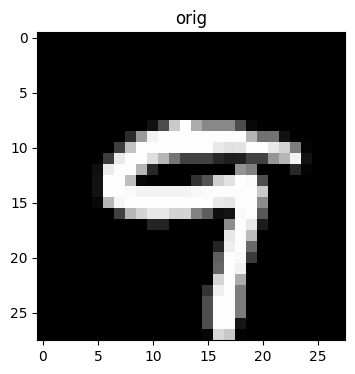

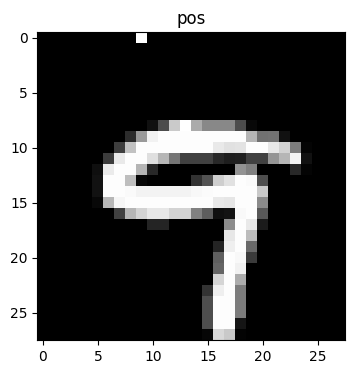

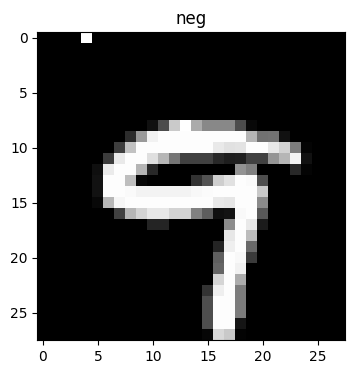

Training layer 0 ...


Training LeakyLayer: 100%|██████████| 1000/1000 [01:17<00:00, 12.95it/s]


Training layer 1 ...


Training LeakyLayer: 100%|██████████| 1000/1000 [00:57<00:00, 17.36it/s]


train error: 14.010000228881836 %


In [ ]:
import matplotlib.pyplot as plt
# for creating plots and visualizations

def overlay_y_on_x(x, y):
# defines a function named 'overlay_y_on_x'
# overlays a one-hot-encoded label 'y' on the input data 'x'
    """Replace the first 10 pixels of data [x] with one-hot-encoded label [y]"""
    # **CLONE INPUT TENSOR**
    x_ = x.clone()
      # creates a copy ('x_') of the input tensor 'x' to avoid modifying the original tensor.

    # **ZERO OUT FIRST 10 PIXELS**
    x_[:, :10] *= 0.0
      # zeros out the first 10 pixels of each example in the input tensor 'x_'.
      # this effectively removes the existing information in these pixels.

    # **ONE-HOT ENCODING**
    x_[range(x.shape[0]), y] = x.max()
      # generates a range of indices corresponding to the number of examples in the input tensor 'x'.
      # selects the elements in 'x_' at positions specified by the label 'y' for each example.
      # this performs a one-hot encoding, setting the value at the position of the label to the maximum value in the original input tensor 'x'.
      # this step replaces the zeros in the first 10 pixels with the maximum value in the corresponding column of the original input tensor for the specified label.
    return x_
      # returns the modified tensor x_, where the first 10 pixels have been replaced with the one-hot-encoded label


# **FUNCTION DEFINITION**
def visualize_sample(data, name='', idx=0):
  # defines a function named 'visualize_sample'.
  # this function is designed to visualize a sample from the input data.

    # **RESHAPE AND MOVE TO CPU**
    reshaped = data[idx].cpu().reshape(28, 28)
      # selects the example at index 'idx' from the input data tensor data.
      # moves the selected example to the CPU. This is relevant if the data is initially on a GPU.
      # reshapes the example into a 28x28 matrix (as the data represents images with a shape of 28x28 pixels).
      # the resulting matrix is assigned to the variable 'reshaped'.

    # **SET FIGURE SIZE**
    plt.figure(figsize = (4, 4))
      # initializes a new figure with a specified size of 4x4 inches.
      # sets up the plotting environment for the image visualization.

    # **SET PLOT TITLE**
    plt.title(name)
      # sets the title of the plot to the value of the 'name' parameter.

    # **DISPLAY IMAGE**
    plt.imshow(reshaped, cmap="gray")
      # displays the reshaped image using the 'imshow' function from Matplotlib.
      # 'cmap="gray"' argument specifies a grayscale color map for displaying the image

    # **SHOW PLOT**
    plt.show()
      # displays the plot with the visualized image.


# **SET RANDOM SEED**
torch.manual_seed(1234)
  # sets the random seed for PyTorch operations (ensures reproducibility).

# **CREATE NEURAL NETWORK**
net = Net([784, 500, 500],"lif")
  # creates an instance of the 'Net' class with a neural network architecture defined by the list [784, 500, 500].
  # this architecture has an input layer with 784 neurons, followed by two hidden layers with 500 neurons each.

# **LOAD AND PRE-PROCESS DATA**
x, y = next(iter(train_loader))
  # loads a batch of training data ('x' and corresponding labels 'y') using the 'train_loader'.
x, y = x.to(device), y.to(device)
  # moves the data to the specified device.

# **OVERLAY LABELS OVER DATA**
x_pos = overlay_y_on_x(x, y)
  # generates positive examples ('x_pos') by overlaying one-hot-encoded labels on the input data.
rnd = torch.randperm(x.size(0))
  # generates a random permutation of indices.
x_neg = overlay_y_on_x(x, y[rnd])
  # generates negative examples ('x_neg') by overlaying one-hot-encoded labels on the input data using the randomly permuted labels.
for data, name in zip([x, x_pos, x_neg], ['orig', 'pos', 'neg']):
    # **VISUALIZE SAMPLES**
    visualize_sample(data, name)
      # displays original ('x'), positive ('x_pos'), and negative ('x_neg') examples.

# **TRAIN THE NEURAL NETWORK**
net.train(x_pos, x_neg)
  # calls the 'train' method of the neural network ('net') with positive and negative examples for training.

# **EVALUATE TRAINING ERROR**
print('train error:', 100*(1.0 - net.predict(x).eq(y).float().mean().item()),'%')
  # performs predictions on the original data ('x') using the trained network, calculates the error rate, and prints it

## 5. Testing the Network

- Load the test data, move it to the appropriate device, use the trained neural network to make predictions on the test set, calculate the error rate, and print the test error. The error rate is calculated as the fraction of incorrectly predicted examples in the test set.
- You should obtain an error of about 13.5%

In [ ]:
# **LOAD AND PRE-PROCESS TEST DATA**
x_te, y_te = next(iter(test_loader))
  # loads a batch of test data ('x_te' and corresponding labels 'y_te') using the 'test_loader'.
x_te, y_te = x_te.to(device), y_te.to(device)
  # moves the test data to the specified device.

# **EVALUATE TEST ERROR**
print('test error:', 100*(1.0 - net.predict(x_te).eq(y_te).float().mean().item()), '%')
  # performs predictions on the test data ('x_te') using the trained network ('net'), calculates the error rate, and prints it.

test error: 13.49000334739685 %


## 6. Plotting the Loss of Each Layer
- The previous Layer and Network code is redefined here, slightly modified to allow for the tracking and plotting of each layer's loss over the given amount of epochs.
- This consumes a lot of GPU RAM, so the size of the model and number of epochs has been greatly reduced.
- The resulting model is quite inaccurate (~89% test error), but provides a good visualization of how each layer's loss decreases over time.

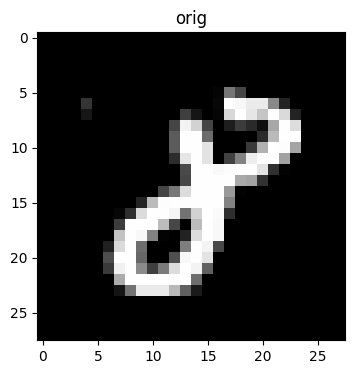

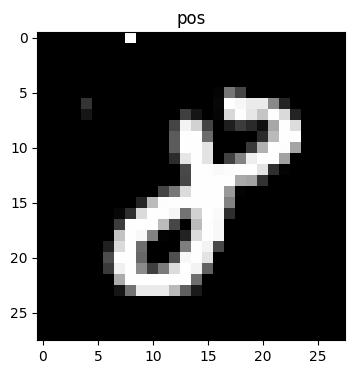

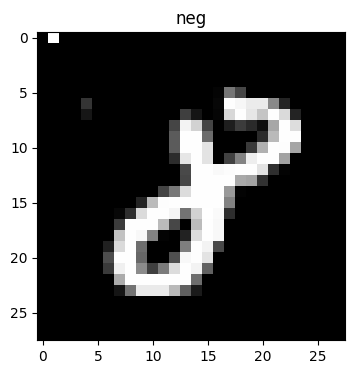

Training layer 0 ...


Training LeakyLayer: 100%|██████████| 100/100 [00:01<00:00, 71.58it/s]


Training layer 1 ...


Training LeakyLayer: 100%|██████████| 100/100 [00:00<00:00, 203.41it/s]


train error: 0.8875799998641014
test error: 0.8872999995946884


In [ ]:
from tqdm import tqdm
from torch.optim import Adam
import matplotlib.pyplot as plt
import torch.nn.functional as F

def overlay_y_on_x(x, y):
    x_ = x.clone()
    x_[:, :10] *= 0.0
    x_[range(x.shape[0]), y] = x.max()
    return x_


class LeakyLayer(nn.Linear):
    def __init__(self, in_features, out_features, bias=False):
        super().__init__(in_features, out_features, bias=bias)
        self.lif = snn.Leaky(beta=0.8)
        self.opt = Adam(self.parameters(), lr=0.03)
        self.threshold = 5.0
        self.num_epochs = 100

    def forward(self, x):
        mem = self.lif.init_leaky()
        x_direction = x / (torch.norm(x, p=2, dim=1, keepdim=True) + 1e-4)
        weighted_input = torch.mm(x_direction, self.weight.T.to(device))
        spk, potential = self.lif(weighted_input, mem)
        return potential

    def train(self, x_pos, x_neg):
        tot_loss = []
        for _ in tqdm(range(self.num_epochs), desc="Training LeakyLayer"):
            g_pos = self.forward(x_pos).pow(2).mean(1)
            g_neg = self.forward(x_neg).pow(2).mean(1)
            loss = F.softplus(torch.cat([-g_pos + self.threshold, g_neg - self.threshold])).mean()
            self.opt.zero_grad()
            loss.backward()
            self.opt.step()
            tot_loss.append(loss)
        return self.forward(x_pos).detach(), self.forward(x_neg).detach(), tot_loss

class Net(nn.Module):
    def __init__(self, dims):
        super().__init__()
        self.layers = nn.ModuleList([
            LeakyLayer(dims[d], dims[d + 1]) for d in range(len(dims) - 1)
        ])

    def predict(self, x):
        goodness_per_label = []
        for label in range(10):
            h = overlay_y_on_x(x, label)
            goodness = []
            for layer in self.layers:
                h = layer(h)
                goodness.append(h.pow(2).mean(1))
            goodness_per_label.append(sum(goodness).unsqueeze(1))
        goodness_per_label = torch.cat(goodness_per_label, 1)
        return goodness_per_label.argmax(1)

    def train(self, x_pos, x_neg):
        h_pos, h_neg = x_pos, x_neg
        layer_losses = []
        for i, layer in enumerate(self.layers):
            print('Training layer', i, '...')
            h_pos, h_neg, tot_loss = layer.train(h_pos, h_neg)
            layer_losses.append(tot_loss)
        return torch.Tensor(layer_losses)

def visualize_sample(data, name='', idx=0):
    reshaped = data[idx].cpu().reshape(28, 28)
    plt.figure(figsize = (4, 4))
    plt.title(name)
    plt.imshow(reshaped, cmap="gray")
    plt.show()


torch.manual_seed(1234)

net = Net([784, 50, 50])
x, y = next(iter(train_loader))
x, y = x.to(device), y.to(device)
x_pos = overlay_y_on_x(x, y)
rnd = torch.randperm(x.size(0))
x_neg = overlay_y_on_x(x, y[rnd])

for data, name in zip([x, x_pos, x_neg], ['orig', 'pos', 'neg']):
    visualize_sample(data, name)

layer_losses = net.train(x_pos, x_neg)

print('train error:', 1.0 - net.predict(x).eq(y).float().mean().item())

x_te, y_te = next(iter(test_loader))
x_te, y_te = x_te.to(device), y_te.to(device)

print('test error:', 1.0 - net.predict(x_te).eq(y_te).float().mean().item())

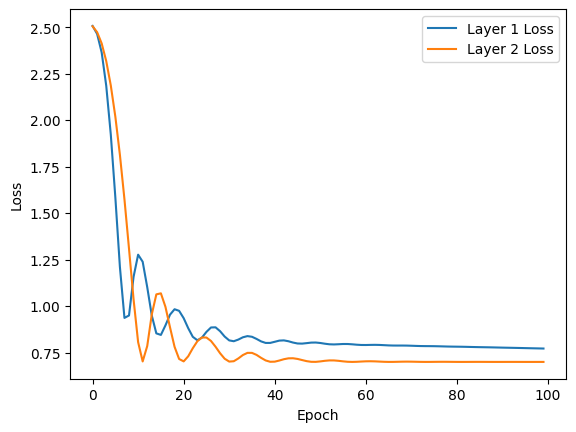

In [ ]:
plt.plot(layer_losses[0,:], label="Layer 1 Loss")
plt.plot(layer_losses[1,:], label="Layer 2 Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Train the Network using ReLU instead of LIF Activation

*   To compare, we can also train and test the same network architecture on the same data, except now using ReLU as the activation function instead of LIF.
*   Running this cell provides a training error and a test error of approximately 10% each.




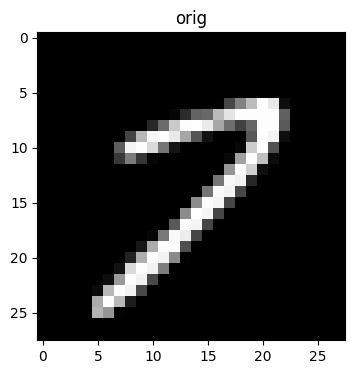

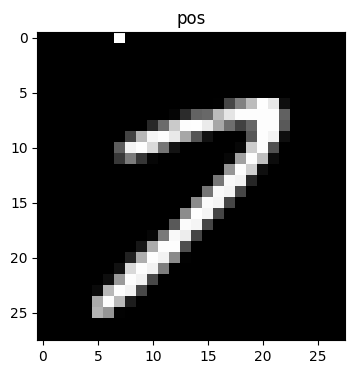

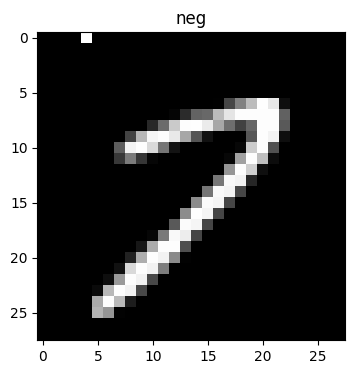

Training layer 0 ...


Training LeakyLayer: 100%|██████████| 1000/1000 [01:00<00:00, 16.45it/s]


Training layer 1 ...


Training LeakyLayer: 100%|██████████| 1000/1000 [00:40<00:00, 24.70it/s]


train error: 10.252004861831665 %
test error: 10.019999742507935 %


In [ ]:
# **CREATE NEURAL NETWORK**
net = Net([784, 500, 500],"relu")
  # creates an instance of the 'Net' class with a neural network architecture defined by the list [784, 500, 500].
  # this architecture has an input layer with 784 neurons, followed by two hidden layers with 500 neurons each.

# **LOAD AND PRE-PROCESS DATA**
x, y = next(iter(train_loader))
  # loads a batch of training data ('x' and corresponding labels 'y') using the 'train_loader'.
x, y = x.to(device), y.to(device)
  # moves the data to the specified device.

# **OVERLAY LABELS OVER DATA**
x_pos = overlay_y_on_x(x, y)
  # generates positive examples ('x_pos') by overlaying one-hot-encoded labels on the input data.
rnd = torch.randperm(x.size(0))
  # generates a random permutation of indices.
x_neg = overlay_y_on_x(x, y[rnd])
  # generates negative examples ('x_neg') by overlaying one-hot-encoded labels on the input data using the randomly permuted labels.
for data, name in zip([x, x_pos, x_neg], ['orig', 'pos', 'neg']):
    # **VISUALIZE SAMPLES**
    visualize_sample(data, name)
      # displays original ('x'), positive ('x_pos'), and negative ('x_neg') examples.

# **TRAIN THE NEURAL NETWORK**
net.train(x_pos, x_neg)
  # calls the 'train' method of the neural network ('net') with positive and negative examples for training.

# **EVALUATE TRAINING ERROR**
print('train error:', 100*(1.0 - net.predict(x).eq(y).float().mean().item()),'%')
  # performs predictions on the original data ('x') using the trained network, calculates the error rate, and prints it

# **LOAD AND PRE-PROCESS TEST DATA**
x_te, y_te = next(iter(test_loader))
  # loads a batch of test data ('x_te' and corresponding labels 'y_te') using the 'test_loader'.
x_te, y_te = x_te.to(device), y_te.to(device)
  # moves the test data to the specified device.

# **EVALUATE TEST ERROR**
print('test error:', 100*(1.0 - net.predict(x_te).eq(y_te).float().mean().item()),'%')
  # performs predictions on the test data ('x_te') using the trained network ('net'), calculates the error rate, and prints it.

# Comparison to ANNs and SNNs using Backpropagation
As shown in [this Keras example](https://www.tensorflow.org/datasets/keras_example), a standard artificial neural network using backpropagation with similar architecure and hyperparameters attains a test set error of about 2.50%.

As shown in [the snnTorch Tutorial 5 documentation](https://snntorch.readthedocs.io/en/latest/tutorials/tutorial_5.html), a spiking neural network using backpropagation with the same architecture and similar set hyperparameters attains a test set error of about 6.13%.

# Conclusion
- We have trained a spiking neural network and standard artificial neural network to classify the MNIST dataset using the Forward-Forward algorithm instead of backpropagation.
- Overall, the Forward-Forward algorithm appears to be a viable method for training neural networks, though it is less performant than using backpropagation.
- The spiking neural network using the Forward-Forward algorithm is less performant than the artifical neural network with ReLU using it. Both perform worse than a spiking neural network or artificial neural network using backpropagation.


# References
> <cite> [Geoffrey Hinton. The Forward-Forward Algorithm: Some Preliminary
Investigations. 2022. arXiv: 2212.13345 [cs.LG].](https://arxiv.org/abs/2212.13345) </cite>

> <cite> [Mohammad Pezeshki. pytorch_forward_forward. Github Repo January 2023.](https://github.com/mpezeshki/pytorch_forward_forward) </cite>